In [1]:
import torch
from torch.utils.data import (
    random_split,
    WeightedRandomSampler,
    DataLoader,
    Dataset,
    Subset
)
from torchvision.models import resnet50, ResNet50_Weights, resnet152, ResNet152_Weights
from efficientnet_pytorch import EfficientNet
from torchvision.datasets import ImageFolder
from torchvision import transforms
from cleanlab.outlier import OutOfDistribution
from cleanlab.rank import find_top_issues
import albumentations

import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, confusion_matrix

import os
import shutil
import math
from random import seed
from collections import Counter, defaultdict
from tqdm import tqdm
from PIL import Image
from IPython import display
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


In [2]:
class config:
    TRAIN_IMAGES = "data/train"
    TEST_IMAGES = "data/test"
    TRAIN_LABELS = "data/train.csv"
    TEST_LABELS = "data/test.csv"

    IMAGENET_MEAN = [0.485, 0.456, 0.406] 
    IMAGENET_STD = [0.229, 0.224, 0.225]
    NUM_CLASSES = 30
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    IMAGE_TYPE = ".jpeg"
    SEED = 42


In [18]:
# torch.cuda.empty_cache()
# print(config.DEVICE)
# print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [4]:
seed(config.SEED)
np.random.seed(config.SEED)
torch.manual_seed(config.SEED)
torch.cuda.manual_seed(config.SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [5]:
# Размещение разных классов по папкам

def moving_images():
    dataset = pd.read_csv(config.TRAIN_LABELS)

    for _, row in dataset.iterrows():
        start_path = os.path.join(config.TRAIN_IMAGES, row["image_id"])
        target_path = os.path.join(config.TRAIN_IMAGES, row["label"])

        if not os.path.isdir(target_path):
            os.mkdir(target_path)

        shutil.move(start_path, target_path)


# moving_images()

In [6]:
class EarlyStopping:
    def __init__(self, patience=1, path='model.pth'):
        self.patience = patience
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, classifier):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(classifier)
        elif val_loss > self.best_score:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.save_checkpoint(classifier)
            self.counter = 0

    def save_checkpoint(self, classifier):
        saving = {
            'classifier': classifier.model.state_dict(),
            'optimizer': classifier.optimizer.state_dict(),
            'class2idx': classifier.class2idx,
            'idx2class': classifier.idx2class,
        }
        torch.save(saving, self.path) 


In [7]:
class SportsClassifier():
    def __init__(
            self,
            num_classes=config.NUM_CLASSES,
            device=config.DEVICE,
            transform=None,
            sample_weights=True,
            loss_weights=True,
            epochs=10,
            batch_size=64,
            lr=1e-3,
            early_stop=True,
    ):

        self.num_classes = num_classes
        self.device = device
        self.transform = transform
        self.sample_weights = sample_weights
        self.loss_weights = loss_weights
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.early_stop = early_stop

    def get_data(self):
        dataset = ImageFolder(config.TRAIN_IMAGES, transform=self.transform)
        train, valid = random_split(
            dataset,
            [math.floor(len(dataset) * 0.8), math.ceil(len(dataset) * 0.2)],
            generator = torch.Generator().manual_seed(config.SEED)
        )
        self.class2idx = dataset.class_to_idx
        self.idx2class = {value: key for key, value in dataset.class_to_idx.items()}

        if self.sample_weights:
            self.train_classes = [label for _, label in train]
            class_count = Counter(self.train_classes)
            class_weights = torch.Tensor(
                [len(self.train_classes) / c for c in pd.Series(class_count).sort_index().values]
                )

            sample_weights = [0] * len(train)
            for idx, (image, label) in enumerate(train):
                class_weight = class_weights[label]
                sample_weights[idx] = class_weight

            sampler = WeightedRandomSampler(
                weights=sample_weights,
                num_samples=len(train),
                replacement=True
            )
            train_loader = DataLoader(
                train, batch_size=self.batch_size, sampler=sampler)
        else:
            train_loader = DataLoader(
                train, batch_size=self.batch_size, shuffle=True)

        valid_loader = DataLoader(valid, batch_size=self.batch_size)

        return train_loader, valid_loader

    def get_model(self, architecture='resnet'):
        if architecture == 'resnet':
            self.model = resnet152(weights=ResNet152_Weights.DEFAULT)
            in_features = self.model.fc.in_features

            for name, param in self.model.named_parameters():
                if ( 
                    "fc" not in name 
                    and "layer4.2" not in name 
                    and "layer4.1" not in name
                    and "layer4.0" not in name
                    and "layer3.35" not in name
                    and "layer3.34" not in name
                    and "layer3.33" not in name
                    and "layer3.32" not in name
                    and "layer3.31" not in name
                    and "layer3.30" not in name
                    and "layer3.29" not in name
                    and "layer3.28" not in name
                    and "layer3.27" not in name
                    and "layer3.26" not in name
                    and "layer3.25" not in name
                    and "layer2.7" not in name
                    and "layer2.6" not in name
                    and "layer2.5" not in name
                    and "layer2.0" not in name
                    and "layer1.2" not in name
                    ):
                    param.requires_grad = False

            self.model.fc = torch.nn.Linear(
                in_features=in_features, out_features=self.num_classes)

        elif architecture == 'efficient-net':
            self.model = EfficientNet.from_pretrained('efficientnet-b4')
            in_features = self.model._fc.in_features

            for name, param in self.model.named_parameters():
                param.requires_grad = False
                
            self.model._fc = torch.nn.Linear(
                in_features=in_features, out_features=self.num_classes)

        self.model = self.model.to(self.device)

        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, weight_decay=0.001, momentum=0.9) 

        if self.loss_weights:
            class_count = Counter(self.train_classes)
            class_weights = torch.Tensor(
                [len(self.train_classes) / c for c in pd.Series(class_count).sort_index().values])
            class_weights = class_weights.to(self.device)
            self.criterion = torch.nn.CrossEntropyLoss(class_weights)
        else:
            self.criterion = torch.nn.CrossEntropyLoss()

    def fit_epoch(self, train_loader):

        train_loss = []
        train_f1 = []

        self.model.train()
        for images, targets in train_loader:
            self.optimizer.zero_grad()

            images = images.to(self.device)
            targets = targets.to(self.device)

            logits = self.model(images)
            loss = self.criterion(logits, targets)
            predictions = torch.argmax(logits, dim=1)

            loss.backward()
            self.optimizer.step()

            train_loss.append(loss.item())
            train_f1.append(f1_score(targets.cpu(), predictions.cpu(), average='micro'))

        return train_loss, train_f1

    def valid_epoch(self, valid_loader):

        valid_loss = []
        valid_f1 = []

        self.model.eval()
        with torch.no_grad():
            for images, targets in valid_loader:
                images = images.to(self.device)
                targets = targets.to(self.device)

                logits = self.model(images)
                loss = self.criterion(logits, targets)
                predictions = torch.argmax(logits, dim=1)

                valid_loss.append(loss.item())
                valid_f1.append(f1_score(targets.cpu(), predictions.cpu(), average='micro'))

        return valid_loss, valid_f1

    def fit(self, train_loader, valid_loader, save_path='model.pth'):
        train_history = defaultdict(list)
        valid_history = defaultdict(list)
        if self.early_stop:
            early_stopping = EarlyStopping(
                patience=3,
                path=save_path
                )

        for epoch in tqdm(range(self.epochs), total=self.epochs):
            train_loss, train_f1 = self.fit_epoch(train_loader)
            valid_loss, valid_f1 = self.valid_epoch(valid_loader)

            train_history["loss"].extend(train_loss)
            train_history["f1"].extend(train_f1)
            valid_history["loss"].extend(valid_loss)
            valid_history["f1"].extend(valid_f1)

            self.plot_loss_and_f1(
                epoch + 1,
                train_history,
                valid_history
            )

            if self.early_stop:
                early_stopping(np.mean(valid_history['loss'][-100:]), self)
                if early_stopping.early_stop:
                    print(f"EarlyStopping: {np.mean(valid_history['loss'][-100:])}")
                    break

    def plot_loss_and_f1(self, epoch, train_history, valid_history):
        display.clear_output(True)
        fig, ax = plt.subplots(2, 2, figsize=(14, 8))
        ax[0, 0].plot(train_history["loss"])
        ax[0, 1].plot(valid_history["loss"])
        ax[1, 0].plot(train_history["f1"])
        ax[1, 1].plot(valid_history["f1"])

        ax[0, 0].set_title(f"Epoch:{epoch} // Train Loss:{np.mean(train_history['loss'][-100:]):.5f}")
        ax[0, 1].set_title(f"Epoch:{epoch} // Validation Loss:{np.mean(valid_history['loss'][-100:]):.5f}")
        ax[1, 0].set_title(f"Epoch:{epoch} // Train F1:{np.mean(train_history['f1'][-100:]):.5f}")
        ax[1, 1].set_title(f"Epoch:{epoch} // Validation F1:{np.mean(valid_history['f1'][-100:]):.5f}")

        plt.show()


In [8]:
augmenter = albumentations.Compose(
    [
        albumentations.ShiftScaleRotate(rotate_limit=0.25, p=0.7),
        albumentations.RandomBrightnessContrast(p=0.4),
        albumentations.RandomGamma(p=0.4),
        albumentations.Blur(blur_limit=2, p=0.1),
        albumentations.GaussNoise((10, 100), p=0.2),
        albumentations.HorizontalFlip(p=0.5)
    ]
)

train_transform = transforms.Compose(
    [
        lambda image: image.convert("RGB"),
        lambda image: augmenter(image=np.array(image))["image"],
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize(config.IMAGENET_MEAN, config.IMAGENET_STD)
    ]
)

test_transform = transforms.Compose(
    [
        lambda image: image.convert("RGB"),
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize(config.IMAGENET_MEAN, config.IMAGENET_STD)
    ]
)

In [10]:
classifier = SportsClassifier(transform=train_transform, loss_weights=False, batch_size=16)

In [11]:
train_loader, valid_loader = classifier.get_data()
len(train_loader), len(valid_loader)

(2767, 692)

In [12]:
# images, labels = next(iter(train_loader))
# classifier.idx2class[labels[1].item()]
# plt.imshow(images[1].permute(1, 2, 0).numpy());

In [ ]:
classifier.get_model(architecture='resnet')

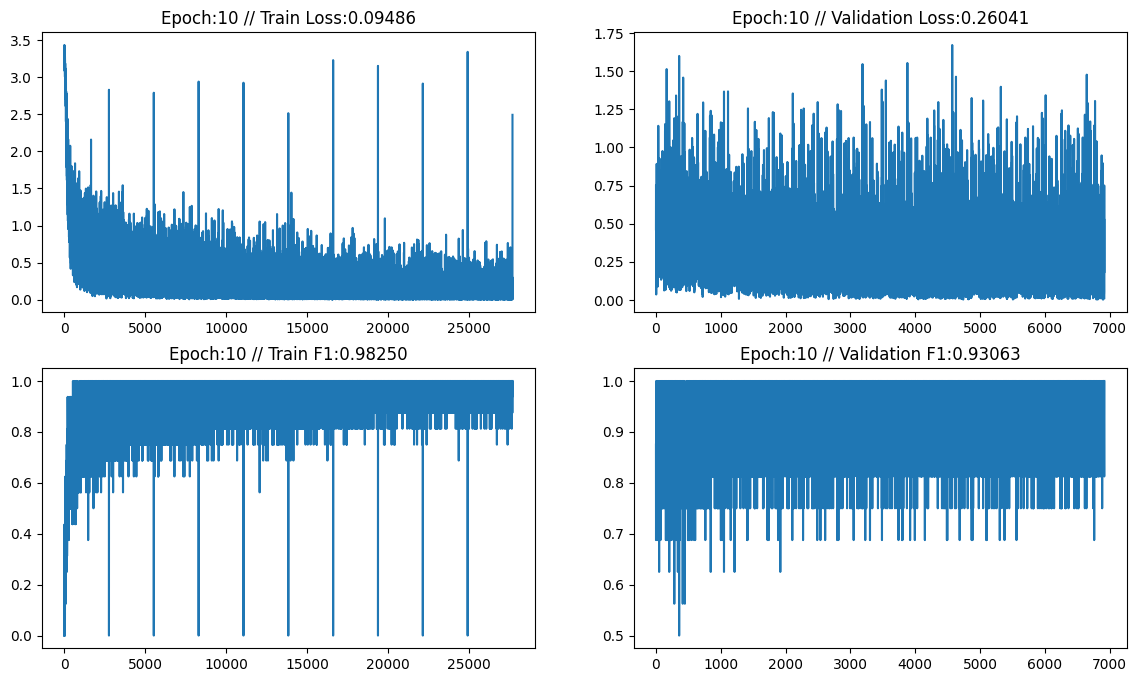

100%|██████████| 10/10 [4:17:41<00:00, 1546.17s/it]


In [16]:
classifier.fit(train_loader=train_loader, valid_loader=valid_loader, save_path='model_13.pth')

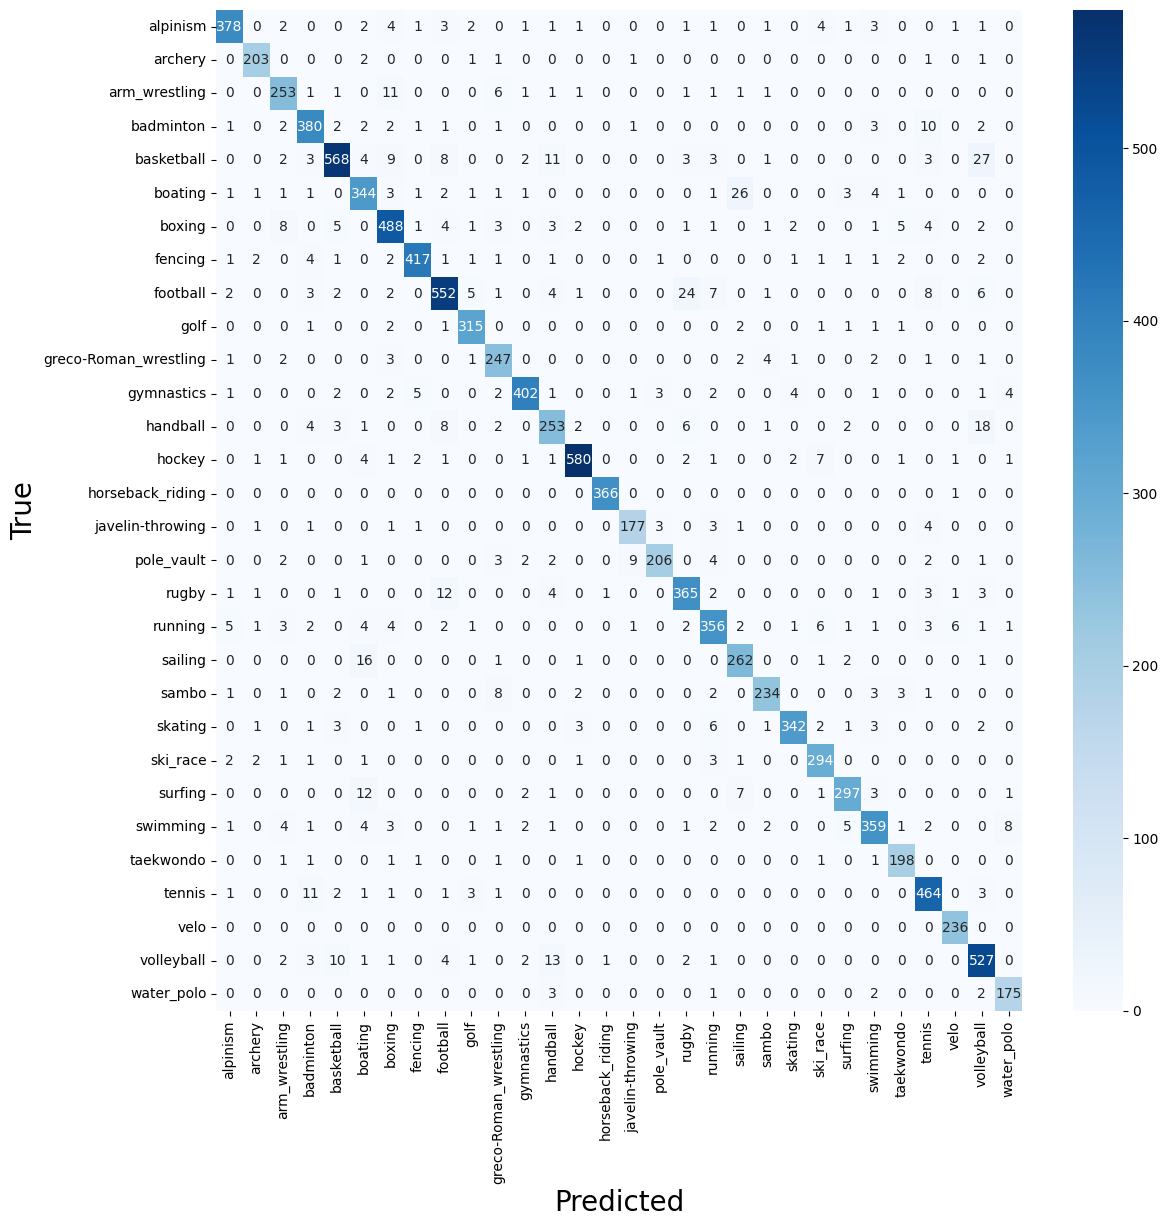

In [22]:
# Матрица путаницы

checkpoint = torch.load("model_13.pth", map_location=torch.device(config.DEVICE))
model = resnet152()
model.fc = torch.nn.Linear(in_features=model.fc.in_features, out_features=config.NUM_CLASSES)
model = model.to(config.DEVICE)
model.load_state_dict(checkpoint["classifier"])

dataset = ImageFolder(config.TRAIN_IMAGES)
classes = dataset.classes

truelabels = []
predictions = []
model.eval()
for data, target in valid_loader:
    data = data.to(config.DEVICE)
    for label in target.data.numpy():
        truelabels.append(label)
    for prediction in model(data).cpu().data.numpy().argmax(1):
        predictions.append(prediction) 

cm = confusion_matrix(truelabels, predictions)
tick_marks = np.arange(len(classes))

df_cm = pd.DataFrame(cm, index=classes, columns=classes)
plt.figure(figsize=(13, 13))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt='g')
plt.xlabel("Predicted", fontsize=20)
plt.ylabel("True", fontsize=20)
plt.show()

In [14]:
class SportsTest(Dataset):
  def __init__(self, path, transform=None):
    self.path = path
    self.transform = transform
    self.images = os.listdir(self.path)  
  
  def __getitem__(self, idx):
    img_path = os.path.join(self.path, self.images[idx])
    img = Image.open(img_path).convert('RGB')
    return self.transform(img), self.images[idx] 

  def __len__(self):
    return len(self.images)


test = SportsTest(config.TEST_IMAGES, transform=test_transform)
test_loader = DataLoader(test, batch_size=32)  

checkpoint = torch.load("model_13.pth", map_location=torch.device(config.DEVICE))
class2idx = checkpoint["class2idx"]
idx2class = checkpoint["idx2class"]

submission = pd.read_csv(config.TEST_LABELS)

In [15]:
model = resnet152()
model.fc = torch.nn.Linear(in_features=model.fc.in_features, out_features=config.NUM_CLASSES)
model = model.to(config.DEVICE)
model.load_state_dict(checkpoint["classifier"])

all_image_id, all_predicted = [], []
model.eval()
with torch.no_grad():
    for image, image_id in test_loader:
        image = image.to(config.DEVICE)
        logits = model(image)
        predicted = torch.argmax(logits, dim=1).cpu().numpy()
        all_image_id.extend(list(image_id))
        all_predicted.extend(list(predicted))

results = pd.DataFrame({"image_id": all_image_id, "label": all_predicted})
submission = pd.merge(submission, results, how="left", on="image_id")
submission["label"] = submission["label"].apply(lambda x: idx2class[x])
submission.to_csv('submission_13.csv', index=False)

In [ ]:
# Дополнительно
# CLEAN LAB для очистки тренировочных данных

dataset = ImageFolder(config.TRAIN_IMAGES, transform=test_transform)
classes = dataset.classes


def deleting_error_imgs(classes):
    for name_class in classes:
        print(f"Class: {name_class}")
            
        dataset = ImageFolder(config.TRAIN_IMAGES, transform=test_transform)
        idx2class = {value: key for key, value in dataset.class_to_idx.items()}

        paths = [path[0] for path in dataset.samples]
        paths = pd.DataFrame(paths, columns=["path"])

        idx = [i for i in range(len(dataset)) if dataset.imgs[i][1] == dataset.class_to_idx[name_class]]
        paths_class = paths.iloc[idx]
        dataset_class = Subset(dataset, idx)
        loader = DataLoader(dataset_class, batch_size=64, shuffle=False)


        def embed_images(model, dataloader):
            feature_embeddings = []
            for data in dataloader:
                images, labels = data
                with torch.no_grad():
                    embeddings = model(images.to(config.DEVICE))
                    feature_embeddings.extend(embeddings.cpu().numpy())
            feature_embeddings = np.array(feature_embeddings)
            return feature_embeddings


        checkpoint = torch.load("model_13.pth", map_location=torch.device(config.DEVICE))
        model = resnet152()
        model.fc = torch.nn.Linear(in_features=model.fc.in_features, out_features=config.NUM_CLASSES)
        model = model.to(config.DEVICE)
        model.load_state_dict(checkpoint["classifier"])

        model.eval() 
        feature_embeddings = embed_images(model, loader)
        print(f'Embeddings pooled shape: {feature_embeddings.shape}')


        def imshow(img):
            npimg = img.numpy()
            return np.transpose(npimg, (1, 2, 0))


        def plot_images(dataset, show_labels=False):
            plt.rcParams["figure.figsize"] = (9, 10)
            for i in range(10):
                X, y = dataset[i]
                ax = plt.subplot(2, 5, i + 1)
                if show_labels:
                    ax.set_title(idx2class[int(y)])
                ax.imshow(imshow(X))
                ax.axis('off')
            plt.show()


        def visualize_outliers(idxs, data):
            data_subset = Subset(data, idxs)
            plot_images(data_subset, show_labels=True)


        ood = OutOfDistribution()
        train_ood_features_scores = ood.fit_score(features=feature_embeddings)
        top_train_ood_features_idxs = find_top_issues(quality_scores=train_ood_features_scores, top=10)
        deleted_files = paths_class.iloc[top_train_ood_features_idxs]

        visualize_outliers(top_train_ood_features_idxs, dataset_class)

        for file in deleted_files.path.tolist():
            os.remove(file)


# deleting_error_imgs(classes)